# Training and Testing an MDRNN on Human Data

This script trains and tests a mixture density recurrent neural network (MDRNN) on a 10-minute human sourced performance.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import sketch_mdn

In [39]:
# Import CSV and create dt 
perf_df = pd.DataFrame.from_csv('./data/2018-01-25T14-04-35-rnnbox.csv', parse_dates=True)
perf_df['time'] = perf_df.index
perf_df['seconds'] = perf_df.index
perf_df.time = perf_df.time.diff()
perf_df.time = perf_df.time.dt.total_seconds()
perf_df = perf_df.dropna()
perf_df.value = perf_df.value / 255.0
corpus_df = pd.DataFrame({'t': perf_df.time, 'x': perf_df.value})
corpus = np.array(corpus_df)
print("Shape of corpus array:", corpus.shape)
corpus_df.describe()
perf_df.seconds = perf_df.seconds - perf_df.seconds[0]
perf_df.seconds = perf_df.seconds.dt.total_seconds()
perf_df.describe()

Shape of corpus array: (13561, 2)


,value,time,seconds
count,13561.000000,13561.000000,13561.000000
mean,0.519052,0.044860,283.243387
std,0.249156,0.183995,180.604910
min,0.000000,0.000454,0.000000
25%,0.349020,0.007978,149.680172
50%,0.525490,0.013049,230.000860
75%,0.713725,0.028018,467.579898
max,1.000000,8.463944,608.350394


In [46]:
corpus

array([[  2.62400000e-03,   4.70588235e-01],
       [  3.40179700e+00,   4.82352941e-01],
       [  5.00200000e-03,   4.94117647e-01],
       ..., 
       [  2.47979000e-01,   2.35294118e-02],
       [  4.59005000e-01,   1.17647059e-02],
       [  4.31041000e-01,   0.00000000e+00]])

## Plot the human performance data

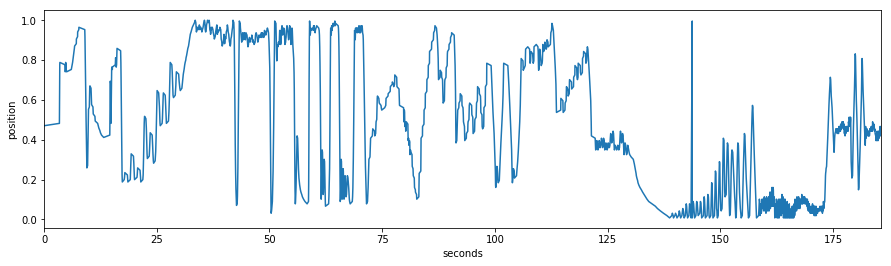

In [45]:
ax = perf_df[:5000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('human_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('human_data_output.png', dpi=300, bbox_inches="tight")

# Train on Human Performance Data

In [ ]:
# Hyperparameters
units = 128
mixes = 8
layers = 3
batch_s = 100
n_steps = 120
epochs = 10

# Train
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_TRAIN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)
loader = sketch_mdn.SequenceDataLoader(num_steps=(n_steps + 1), batch_size=batch_s, corpus=corpus)
losses = net.train(loader, epochs, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()

INFO:tensorflow:Loading Training Operations
INFO:tensorflow:done initialising: mixture-rnn-3layers-128units vars: 336432
Total training examples: 13439
Done initialising loader.
INFO:tensorflow:going to train: mixture-rnn-3layers-128units
INFO:tensorflow:trained epoch 0 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-3layers-128units-20180125-153740/mixture-rnn-3layers-128units.ckpt, global_step 134.
INFO:tensorflow:trained epoch 1 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-3layers-128units-20180125-153740/mixture-rnn-3layers-128units.ckpt, global_step 268.
INFO:tensorflow:trained epoch 2 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-3layers-128units-20180125-153740/mixture-rnn-3layers-128units.ckpt, global_step 402.
INFO:tensorflow:trained epoch 3 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-3layers-128units-20180125-153740/mixture-rnn-3layers-128units.ckpt, global_step 536.
INFO:tensorflow:trained epoch 4 of 10
INFO:tensor

# Test the Human Data Network

In [ ]:
# Hyperparameters
units = 128
mixes = 8
layers = 3
n_steps = 1
batch_s = 1

# Instantiate Running Network
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_RUN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)

first_touch = np.array([(0.01 + (np.random.rand()-0.5)*0.005), np.random.rand()])
print("Test Input:",first_touch)

with tf.Session() as sess:
    perf = net.generate_performance(first_touch,1000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'t':perf.T[0], 'x':perf.T[1]})
perf_df['time'] = perf_df.t.cumsum()
#plt.show(perf_df.plot('time','x',kind='scatter'))
plt.plot(perf_df.time, perf_df.x, '.r-')
plt.show()
print(perf_df.describe())

# ## Investigate Output
# window = 100
# for n in [1000,2000,3000,4000,5000,6000]:
#     print("Window:", str(n),'to',str(n+window))
#     plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
#     plt.show()

# input_touch = first_touch.reshape([1,1,net.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
# if net.state is not None:
#     feed = {net.x: input_touch, net.init_state: net.state}
# else:
#     feed = {net.x: input_touch}
# pis, locs_1, locs_2, scales_1, scales_2, corr, net.state = sess.run([net.pis, net.locs_1, net.locs_2, net.scales_1, net.scales_2,  net.corr, net.final_state], feed_dict=feed)
# #x_1, x_2 = sketch_mixture.sample_mixture_model(pis, locs_1, locs_2, scales_1, scales_2, corr, temp=1.0, greedy=False)

